###AUTHOR 1: Saad Abdullah, Scrapped cheapoair, Participated in EDA and Built User Interface.

###AUTHOR 2: Abdul Wahab, Scrapped trip.com, Participated in EDA, code-cleanup & documentation

###AUTHOR 3: Lameya Islam, Scrapped hotelworld.com, Participated in EDA.

# Package Installation

In [ ]:
!apt-get update
!pip install requests
!pip install beautifulsoup4
!pip install pandas
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install chromedriver-autoinstaller selenium-stealth
!pip install selenium

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Ign:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy Release
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 261 kB in 2s (136 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not s

##**STEP 1: Web Scraping Overview**


*   We scrape hotel data for **Dubai** from **Cheapoair**, **Trip.com**, and **HostelWorld** for the dates **January 1-2, 2025**.
*   Key data: hotel name, rating, review count, price, refund policy, stars, address, and images.
*   Challenges include bypassing bot detection, scrolling to load all data, and handling lazy-loaded elements.

#### This section scrapes data from three sites using individual functions (e.g., scrape_cheapoair_hotels). Each function returns a DataFrame, and the DataFrames are combined for further EDA. You can adjust **PAGE_COUNT** for variable results





In [ ]:
import chromedriver_autoinstaller
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
import time
import pandas as pd
from bs4 import BeautifulSoup
from selenium_stealth import stealth
import requests
import pdb

#number of pages to scrape from each site, for cheapoair we can go upto 50 pages around 500 records. But it will take alot time to scrap wo to save time keeping it for 15 pages right now.
PAGE_COUNT = 15


# Create a driver function for both scrapers
def create_driver():
    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument("--headless")
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    driver = webdriver.Chrome(options=chrome_options)

    # Stealth settings to avoid detection
    stealth(driver,
            languages=["en-US", "en"],
            vendor="Google Inc.",
            platform="Win32",
            webgl_vendor="Intel Inc.",
            renderer="Intel Iris OpenGL Engine",
            fix_hairline=True,
    )

    return driver

# Function to load and scroll the page
def load_and_scroll_page(url, driver, scroll_pause_time=3, max_scrolls=2):
    driver.get(url)
    time.sleep(5)  # Give the page initial time to load
    last_height = driver.execute_script("return document.body.scrollHeight")

    for _ in range(max_scrolls):
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(scroll_pause_time)
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height

    return driver.page_source


# Function to scrape Cheapoair hotel data
def scrape_cheapoair_hotel(base_url, pages=7):
    driver = create_driver()
    all_hotels_data = []

    for page in range(1, pages + 1):
        url = f"{base_url}&page={page}"
        driver.get(url)
        time.sleep(20)
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        hotels_list = soup.find_all('div', class_='mfhotel-0')

        hotels_data = []
        for hotel in hotels_list:
            hotel_name_span = hotel.find('span', {'data-test': 'hotelName'})
            review_box = hotel.find('div', {'data-test': 'reviewBox'})
            rating = review_box.find('b').get_text(strip=True) if review_box and review_box.find('b') else 'N/A'
            review_count = review_box.find('p', class_='MuiTypography-root MuiTypography-body2 mfhotel-mgnx2q').get_text(strip=True) if review_box and review_box.find('p', class_='MuiTypography-root MuiTypography-body2 mfhotel-mgnx2q') else 'N/A'
            priceBox = hotel.find('h2', {'data-test': 'priceBox'})
            price = priceBox.get_text(strip=True) if priceBox else 'N/A'
            refundable_span = hotel.find('span', {'aria-label': 'Refundable booking'})
            refundable = 'Yes' if refundable_span else 'No'
            hotel_address_span = hotel.select_one('span:nth-of-type(3)')
            hotel_address = hotel_address_span.get_text(strip=True) if hotel_address_span else 'N/A'
            star_span = hotel.find('span', {'aria-label': lambda x: x and 'Star Hotel' in x and len(x) <= 12})
            stars = star_span['aria-label'] if star_span else 'N/A'
            hotel_images = [img.get('src') for img in hotel.find_all('img', class_='MuiBox-root mfhotel-1se2dj0')]
            if hotel_name_span:
                hotels_data.append({
                    'Hotel Name': hotel_name_span.get_text(strip=True),
                    'Hotel Rating': rating,
                    'Review Count': review_count,
                    'Price': price,
                    'Refundable': refundable,
                    'Stars': stars,
                    'Hotel Address': hotel_address,
                    'Images': hotel_images,
                    'Source': 'Cheapoair.com'
                })

        all_hotels_data.extend(hotels_data)

    driver.quit()
    return pd.DataFrame(all_hotels_data)


# Function to scrape Trip.com hotel data
def scrape_trip_hotel(base_url, pages=10):
    driver = create_driver()
    all_hotels_data = []

    for page in range(1, pages + 1):
        url = f"{base_url}&page={page}"
        page_source = load_and_scroll_page(url, driver)
        soup = BeautifulSoup(page_source, 'html.parser')
        hotel_cards = soup.find_all('div', class_='hotel-info')

        hotels_data = []
        for hotel_card in hotel_cards:
            hotel = hotel_card.find('div', class_='rt imgSizeVersionB')
            img_div = hotel_card.find('div', class_='multi-images')
            image_urls = [img.get('src') for img in img_div.find_all('img')] if img_div else []
            hotel_name = hotel.find('span', class_='name')
            name = hotel_name.get_text().strip() if hotel_name else 'N/A'

            if name == 'N/A':
                hotel_name = hotel.find('a', class_='name')
                name = hotel_name.get_text().strip() if hotel_name else 'N/A'

            rating_div = hotel.find('div', class_='score')
            rating_span = rating_div.find('span', class_='real') if rating_div else None
            rating = round(float(rating_span.get_text().strip()) * 2, 1) if rating_span else 'N/A'
            count_div = hotel.find('div', class_='count')
            review_anchor = count_div.find('a') if count_div else None
            review_count = review_anchor.get_text().replace(',', '') if review_anchor else 'N/A'
            refund_span = hotel.find('span', class_='highlight-tag')
            refundable = 'Yes' if refund_span and 'Free Cancellation' in refund_span.get_text() else 'No'
            price_div = hotel.find('div', id='meta-real-price')
            price_span = price_div.find('span') if price_div else None
            price = price_span.get_text().replace(",", "").replace("US", "USD").replace("$", '') if price_span else 'N/A'
            address_para = hotel.find('p', class_='transport')
            address = address_para.get_text().replace('Show on Map', '').replace('  ', ', ') if address_para else 'N/A'

            hotels_data.append({
                'Hotel Name': name,
                'Hotel Rating': rating,
                'Review Count': f"({review_count})",
                'Price': price,
                'Refundable': refundable,
                'Stars': 'N/A',
                'Hotel Address': address,
                'Images': image_urls,
                'Source': 'Trip.com'
            })

        all_hotels_data.extend(hotels_data)

    driver.quit()
    return pd.DataFrame(all_hotels_data)


def scrape_hostelworld(base_url, pages=3):
    # Set up Selenium WebDriver
    options = Options()
    options.add_argument('--headless')  # Run in headless mode (without GUI)
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')

    # Initialize WebDriver
    driver = webdriver.Chrome(options=options)

    # Apply stealth settings to avoid detection
    stealth(driver,
        languages=["en-US", "en"],
        vendor="Google Inc.",
        platform="Win32",
        webgl_vendor="Intel Inc.",
        renderer="Intel Iris OpenGL Engine",
        fix_hairline=True,
    )

    all_hostels_data = []

    # Loop through each page
    for page in range(1, pages + 1):
        # Construct the URL for the current page
        url = f"{base_url}&page={page}"

        driver.get(url)

        # Wait for the page to fully load
        time.sleep(3)

        # Scroll to the bottom of the page to trigger lazy loading
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(2)  # Wait a bit for lazy loaded content to appear

        # Parse the page with BeautifulSoup
        soup = BeautifulSoup(driver.page_source, 'html.parser')

        # Find all hotel cards
        hotels_list = soup.find_all('div', class_='property-card')

        # Iterate through each hotel card and extract information
        for hotel in hotels_list:
            if hotel.find_parent('div', class_='featured-container'):
                continue

            # Hotel Name
            name_div = hotel.find('div', class_='property-name')
            if name_div:
                hotel_name = name_div.find('span').get_text(strip=True) if name_div.find('span') else name_div.get_text(strip=True)
            else:
                hotel_name = 'N/A'

            # Address
            address_span = hotel.find('span', class_='distance-description')
            address = address_span.get_text(strip=True) if address_span else 'N/A'

            rating_span = hotel.find('span', class_='score')
            if rating_span:
                rt_txt = rating_span.get_text(strip=True)
                rt = 0 if rt_txt == 'NEW' else rt_txt
                rating = float(rt)
            else:
                rating = 'N/A'

            # Number of Reviews
            reviews_span = hotel.find('span', class_='num-reviews left-margin')
            reviews = reviews_span.get_text(strip=True) if reviews_span else 'N/A'

            # Hotel Image URL using Selenium
            image_div = hotel.find('div', class_='carousel-list')
            img_tag = image_div.find('img') if image_div else None

            # Scroll to the image to trigger loading
            if img_tag:
                image_url = img_tag['src'] if img_tag else 'N/A'
                if image_url.startswith("data:image/gif;base64"):
                    image_url = img_tag.get('data-v-lazy') or img_tag['src']  # Try to fetch lazy-loaded src
            else:
                image_url = 'N/A'

            # Prices (handling dorm and private accommodation)
            prices_divs = hotel.find_all('div', class_='property-accommodation-prices')
            price = 'N/A'  # Default price value

            refundable_tag = hotel.find('div', class_='tag-text')
            if refundable_tag and 'Free Cancellation' in refundable_tag.get_text(strip=True):
                refundable = 'Yes'
            else:
                refundable = 'No'

            if len(prices_divs) >= 1:
                price_strong_1 = prices_divs[0].find('strong', class_='current')
                price_1 = price_strong_1.get_text(strip=True).replace('$', '') if price_strong_1 else None
                if price_1:
                    price = price_1  # Take the first price if available
                elif len(prices_divs) >= 2:
                    price_strong_2 = prices_divs[1].find('strong', class_='current')
                    price_2 = price_strong_2.get_text(strip=True).replace('$', '') if price_strong_2 else 'N/A'
                    price = price_2 if price_2 else price  # Fallback to the second price

            # Store the hotel data
            all_hostels_data.append({
                'Hotel Name': hotel_name,
                'Hotel Rating': rating,
                'Review Count': reviews,
                'Price': f"${price}",
                'Refundable': refundable,
                'Stars': 'N/A',
                'Hotel Address': address,
                'Images': [image_url],
                'Source': 'HostelWorld.com'
            })

    # Close the Selenium WebDriver
    driver.quit()

    # Convert the list of hotels into a DataFrame
    df = pd.DataFrame(all_hostels_data)

    # Save DataFrame to CSV
    df.to_csv('hostels_data.csv', index=False)

    # Return the DataFrame
    return df


#SITE1: cheapoair.com
cheapoair_base_url = 'https://www.cheapoair.com/trip/hotels?ht=1&r1=a1ch0&ad=1&childs=0&rooms=1&fromdt=01%2F01%2F2025&todt=01%2F02%2F2025&dest=6145&modified=true'
#SITE2: trip.com
trip_base_url = 'https://www.trip.com/hotels/list?city=220&cityName=Dubai&provinceId=10965&countryId=9&districtId=0&checkin=2025%2F01%2F01&checkout=2025%2F01%2F02&lowPrice=0&highPrice=-1&barCurr=USD&crn=1&adult=1&children=0&searchBoxArg=t&travelPurpose=0&ctm_ref=ix_sb_dl&domestic=true&listFilters=17%7C1*17*1*2%2C80%7C0%7C1*80*0*2%2C29%7C1*29*1%7C1*2&locale=en-XX&curr=USD'
#SITE3: hostelworld.com
hostelworld_base_url = 'https://www.hostelworld.com/pwa/wds/s?q=Dubai,%20United%20Arab%20Emirates&country=Dubai&city=Dubai&type=city&id=1177&from=2025-01-01&to=2025-01-02&guests=1'

cheapoair_data_df = scrape_cheapoair_hotel(cheapoair_base_url, pages=PAGE_COUNT)
trip_data_df = scrape_trip_hotel(trip_base_url, pages=PAGE_COUNT)
hostelworld_df = scrape_hostelworld(hostelworld_base_url, pages=PAGE_COUNT)


# Merge the data from multiple sites
hotel_data_df = pd.concat([cheapoair_data_df, trip_data_df, hostelworld_df], ignore_index=True)

print(hotel_data_df)


                                        Hotel Name Hotel Rating  \
0                              Wyndham Dubai Deira          8.4   
1                                  Pullman Sharjah          8.8   
2                                 Mount Sina Hotel          N/A   
3                Days Hotel By Wyndham Dubai Deira          7.9   
4          The George Hotel by Saffron Dubai Creek          8.2   
..                                             ...          ...   
953                            Lotus Retreat Hotel          5.3   
954  Hafez Hotel Apartments - Al Ras Metro Station          4.0   
955                      Signature inn Hotel Deira          4.9   
956                   Frank & Frank Vacation Homes          N/A   
957                 Al Manar Grand Hotel Apartment          N/A   

       Review Count      Price Refundable         Stars  \
0    (201  Reviews)     USD269         No  4 Star Hotel   
1    (204  Reviews)     USD184         No  5 Star Hotel   
2               N/

**Raw Hotel Data Count from Each Source**


*   This block shows a bar chart of raw hotel counts from each source.
*   Data is grouped by the **Source** column.
*   Visualizes how much data was scraped from **Cheapoair**, **Trip.com**, and **HostelWorld** before any processing.






Source
Trip.com           170
Cheapoair.com      125
HostelWorld.com     83
Name: count, dtype: int64


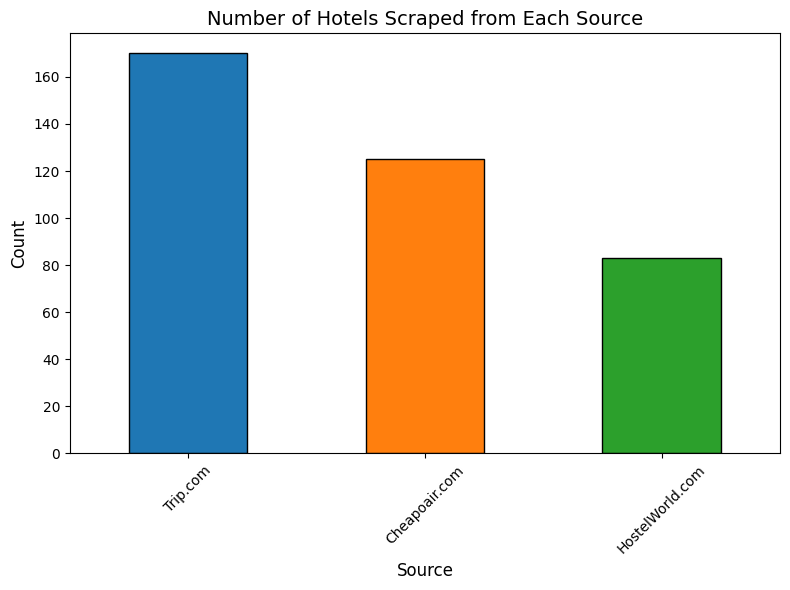

In [ ]:
import matplotlib.pyplot as plt

# Count the number of entries from each source
site_counts = hotel_data_df['Source'].value_counts()
print(site_counts)

# Plot a bar chart
plt.figure(figsize=(8, 6))
site_counts.plot(kind='bar', color=['#1f77b4', '#ff7f0e', '#2ca02c'], edgecolor='black')
plt.title('Number of Hotels Scraped from Each Source', fontsize=14)
plt.xlabel('Source', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


##**Step 2: Data Preprocessing**

*   Combined the dataframes from three websites into a single.
*   Dropped the duplicate rows based on image

*   Mapped Refundable column to binary value i.e, (Yes = 1, No = 0)
*   Cleaned Price of symbols i.e, ($, USD etc.) and converted to float

*   Hotel Rating and Review Count converted to numeric format










In [ ]:
hotel_data_df['Images'] = hotel_data_df['Images'].apply(tuple)
duplicate_count = hotel_data_df.duplicated().sum()

print(f'There are {duplicate_count} duplicate rows in the DataFrame.')



There are 130 duplicate rows in the DataFrame.


In [ ]:
# Remove duplicates from the DataFrame

hotel_data_df_cleaned = hotel_data_df.drop_duplicates()

# Optionally, reset the index after dropping duplicates
hotel_data_df_cleaned.reset_index(drop=True, inplace=True)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [ ]:
df = pd.DataFrame(hotel_data_df_cleaned)
df['Hotel Rating'] = pd.to_numeric(df['Hotel Rating'], errors='coerce')
df['Review Count'] = df['Review Count'].astype(str).str.extract('(\d+)').astype(float)  # Extract numerical part

#convert the price to float
df['Price'] = df["Price"].replace({r'[\$,USD,NT,/A]': '', r',': '', r'\s': '', r'\?':'', '': ''}, regex=True)
df['Price'].replace('', np.nan,inplace=True)
df['Price'] = df['Price'].astype(float)
df.dropna(subset=['Price'], inplace=True)

# invalid_price_rows = df[pd.to_numeric(df['Price'].str.replace(r'[\$,USD,NT]', '', regex=True), errors='coerce').isna()]
# print(invalid_price_rows)
df['Refundable'] = df['Refundable'].map({'Yes': 1, 'No': 0})  # Convert to binary
df['Stars'] = df['Stars'].replace({'5 Star Hotel': 5, '4 Star Hotel': 4, '3 Star Hotel': 3, '2 Star Hotel': 2, '1 Star Hotel': 1, 'N/A': None})

<ipython-input-85-4dd70d9b5497>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Price'].replace('', np.nan,inplace=True)
<ipython-input-85-4dd70d9b5497>:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Stars'] = df['Stars'].replace({'5 Star Hotel': 5, '4 Star Hotel': 4, '3 Star Hotel': 3, 

##**STEP 3: Exploratory Data Analysis (EDA)**

#### Used Summary Statistics df.describe() to quickly summarize key metrics like averages and ranges, helping identify trends and outliers.

In [ ]:
# Summary Statistics
print(df.describe())

       Hotel Rating  Review Count         Price  Refundable      Stars
count     74.000000     74.000000     86.000000   86.000000  39.000000
mean       8.252703    234.527027    572.313953    0.302326   3.769231
std        0.865349    203.297961   2487.748513    0.461959   1.111224
min        4.600000     40.000000     10.000000    0.000000   1.000000
25%        7.800000    151.750000    153.000000    0.000000   3.000000
50%        8.400000    194.500000    207.500000    0.000000   4.000000
75%        8.800000    220.500000    312.250000    1.000000   5.000000
max        9.500000   1132.000000  22488.000000    1.000000   5.000000


#### Used histograms to visualize the distribution of hotel ratings, review counts, and prices. It helps quickly understand the spread and frequency of these key metrics across the dataset.

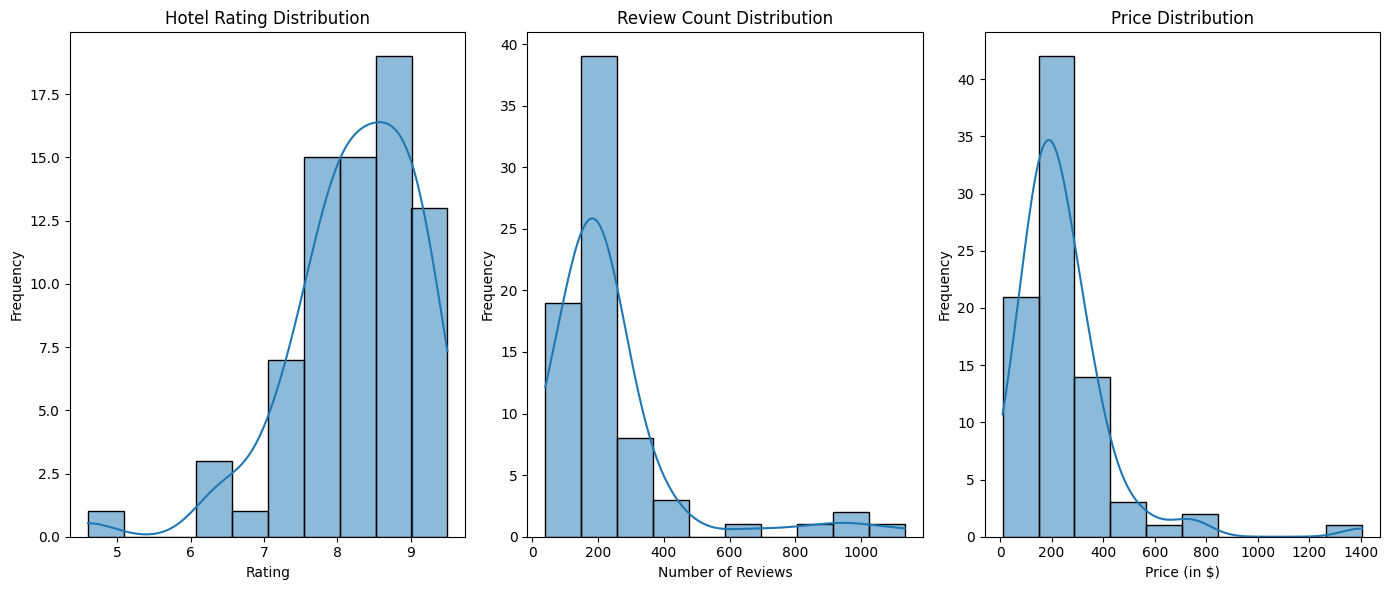

In [ ]:
# Histograms
plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 1)
sns.histplot(df['Hotel Rating'], bins=10, kde=True)
plt.title('Hotel Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
sns.histplot(df['Review Count'], bins=10, kde=True)
plt.title('Review Count Distribution')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
#removing extra skewed data from price comparisons to have meaningful EDA
price_df = df[df['Price'] <= 5000]
sns.histplot(price_df['Price'], bins=10, kde=True)
plt.title('Price Distribution')
plt.xlabel('Price (in $)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

#### Used correlation heatmap to visualize the relationships between numerical variables (e.g., rating, review count, price). It helps see which variables are strongly correlated, aiding in understanding potential connections within the dataset

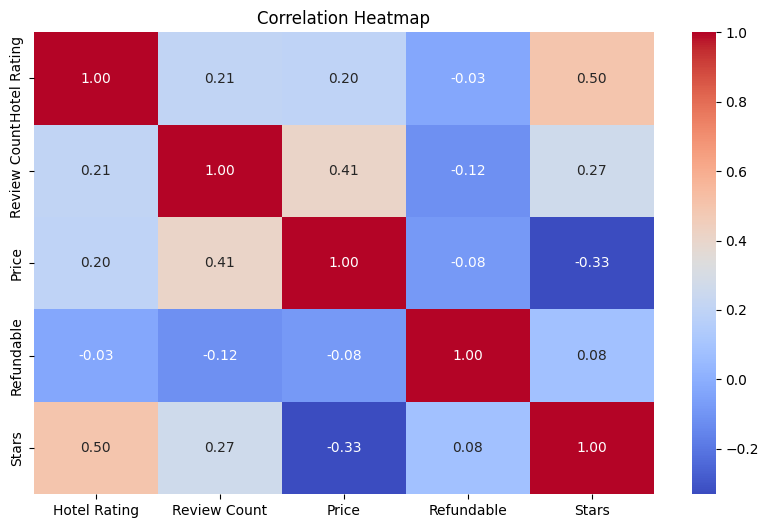

In [ ]:
# Correlation Heatmap
plt.figure(figsize=(10, 6))
correlation_matrix = df[['Hotel Rating', 'Review Count', 'Price', 'Refundable', 'Stars']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

#### Used Boxplots to compare hotel ratings based on start levels, with refundabilitiy as a distinguishing factor. It helps analyze how ratings vary by star classification and whether refundability impacts the ratings

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future ve

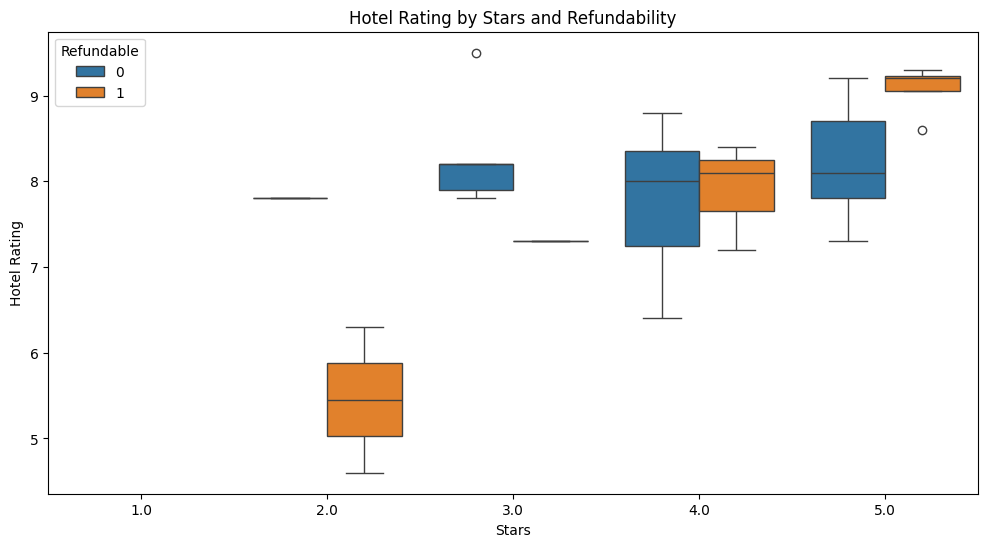

In [ ]:
# Boxplots to compare ratings
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Stars', y='Hotel Rating', hue='Refundable')
plt.title('Hotel Rating by Stars and Refundability')
plt.xlabel('Stars')
plt.ylabel('Hotel Rating')
plt.legend(title='Refundable')
plt.show()

In [ ]:
print(df[['Stars', 'Hotel Rating', 'Refundable']].info())

<class 'pandas.core.frame.DataFrame'>
Index: 86 entries, 0 to 85
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Stars         39 non-null     float64
 1   Hotel Rating  74 non-null     float64
 2   Refundable    86 non-null     int64  
dtypes: float64(2), int64(1)
memory usage: 2.7 KB
None


#### This section checks skewness in ratings, reviews, and prices, and performs a T-test to compare hotel ratings between refundable and non-refundable options. Results are interpreted based on the p-value.

In [ ]:
# Skewness
print("Skewness of the Hotel Rating:", df['Hotel Rating'].skew())
print("Skewness of the Review Count:", df['Review Count'].skew())
print("Skewness of the Price:", df['Price'].skew())

# Inference Statistics: T-test for hotel ratings based on refundable status
from scipy import stats

refundable_ratings = df[df['Refundable'] == 1]['Hotel Rating'].dropna()
non_refundable_ratings = df[df['Refundable'] == 0]['Hotel Rating'].dropna()

t_stat, p_val = stats.ttest_ind(refundable_ratings, non_refundable_ratings)
print(f"T-test: t-statistic = {t_stat:.2f}, p-value = {p_val:.4f}")

# Interpretation of the T-test
if p_val < 0.05:
    print("There is a significant difference in hotel ratings based on refundable status.")
else:
    print("There is no significant difference in hotel ratings based on refundable status.")


Skewness of the Hotel Rating: -1.3415378791525285
Skewness of the Review Count: 2.82307470744564
Skewness of the Price: 8.384209510189633
T-test: t-statistic = -0.28, p-value = 0.7801
There is no significant difference in hotel ratings based on refundable status.


#### This scatter plot visualizes the relationship between hotel price and rating, helping to identify any trends or correlations between these two variables.


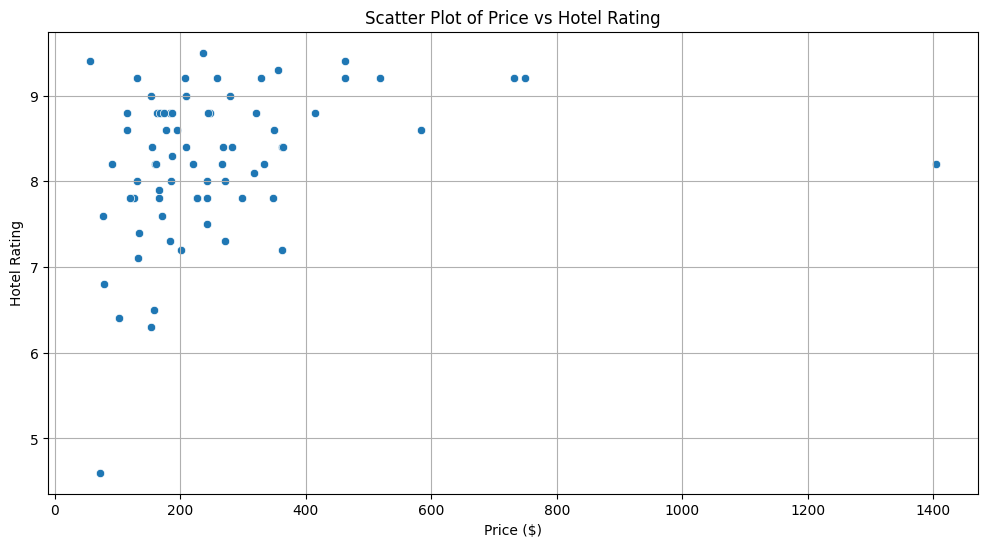

In [ ]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Price', y='Hotel Rating', data=price_df)
plt.title('Scatter Plot of Price vs Hotel Rating')
plt.xlabel('Price ($)')
plt.ylabel('Hotel Rating')
plt.grid()
plt.show()

#### This section categorizes hotel prices into defined bins and creates a boxplot to compare hotel ratings across different price ranges, helping to see how ratings vary with price levels.

<ipython-input-125-84ddd5b7b6d3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['Price Range'] = pd.cut(price_df['Price'], bins=bins, labels=labels)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


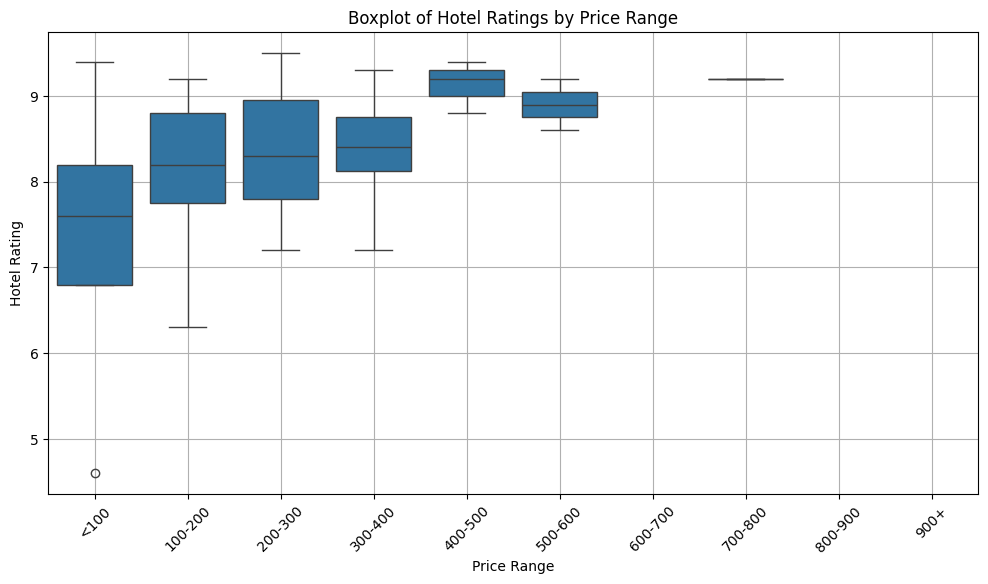

In [ ]:
# Define price bins
bins = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
labels = ['<100', '100-200', '200-300', '300-400', '400-500', '500-600', '600-700', '700-800', '800-900', '900+']
price_df['Price Range'] = pd.cut(price_df['Price'], bins=bins, labels=labels)

plt.figure(figsize=(12, 6))
sns.boxplot(x='Price Range', y='Hotel Rating', data=price_df)
plt.title('Boxplot of Hotel Ratings by Price Range')
plt.xlabel('Price Range')
plt.ylabel('Hotel Rating')
plt.grid()
plt.xticks(rotation=45)
plt.show()


#### This boxplot visualizes the relationship between hotel ratings and star ratings, helping us understand how ratings differ based on the number of stars a hotel has.








/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


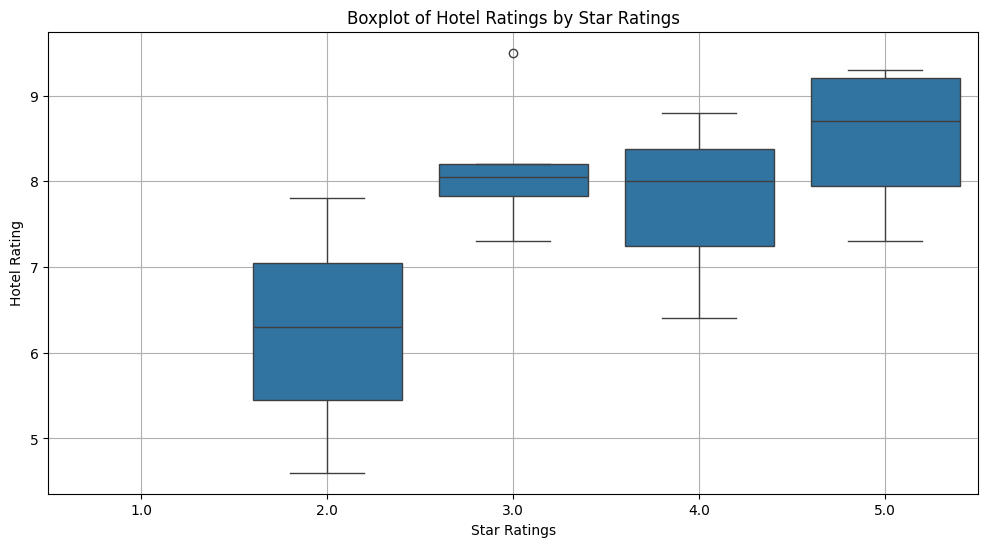

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Stars', y='Hotel Rating', data=df)
plt.title('Boxplot of Hotel Ratings by Star Ratings')
plt.xlabel('Star Ratings')
plt.ylabel('Hotel Rating')
plt.grid()
plt.show()


#### This boxplot compares hotel prices across different star ratings, showing how the price of accommodations varies with the star rating.


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


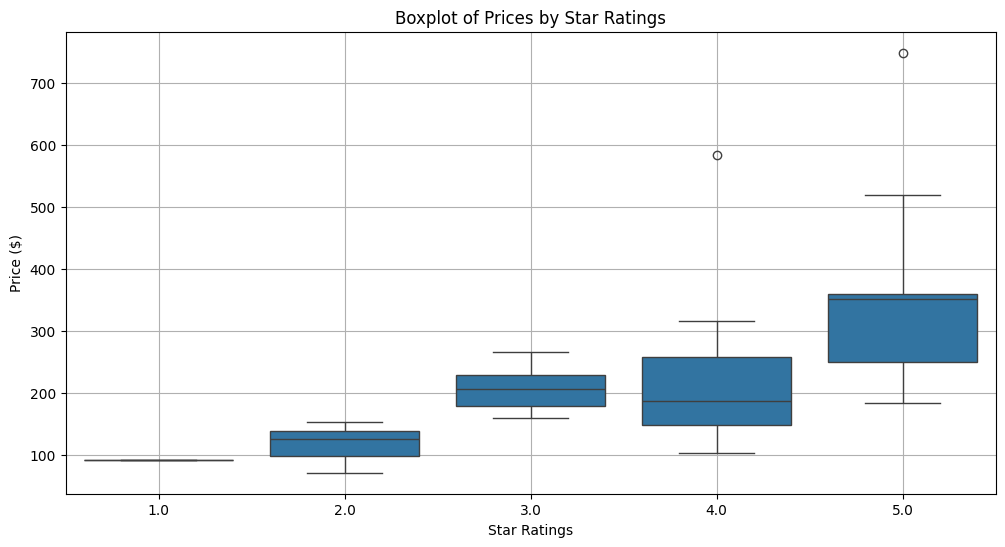

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Stars', y='Price', data=price_df)
plt.title('Boxplot of Prices by Star Ratings')
plt.xlabel('Star Ratings')
plt.ylabel('Price ($)')
plt.grid()
plt.show()


#### This section creates price ranges and filters hotels with 3-star and 4-star ratings. The two filtered DataFrames are then merged based on the price range to compare hotel ratings between 3-star and 4-star hotels within the same price range.

In [ ]:
# Define price bins and labels
price_bins = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
price_labels = ['<100', '100-200', '200-300', '300-400', '400-500', '500-600', '600-700', '700-800', '800-900', '900+']

# Create a new column for price ranges
df['Price Range'] = pd.cut(df['Price'], bins=price_bins, labels=price_labels)


In [ ]:
# Get the hotels with 3-star and 4-star ratings
three_star_hotels = df[df['Stars'] == 3].copy()
four_star_hotels = df[df['Stars'] == 4].copy()

# Merge the two DataFrames on 'Price Range'
common_hotels = pd.merge(
    three_star_hotels[['Price Range', 'Hotel Rating']],
    four_star_hotels[['Price Range', 'Hotel Rating']],
    on='Price Range',
    suffixes=('_3_star', '_4_star')
)


In [ ]:
rating_comparison_stats = common_hotels.describe()
print(rating_comparison_stats)


       Hotel Rating_3_star  Hotel Rating_4_star
count            39.000000            46.000000
mean              8.069231             7.780435
std               0.644472             0.737449
min               7.300000             6.400000
25%               7.800000             7.200000
50%               7.900000             8.000000
75%               8.200000             8.400000
max               9.500000             8.800000


/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future ve

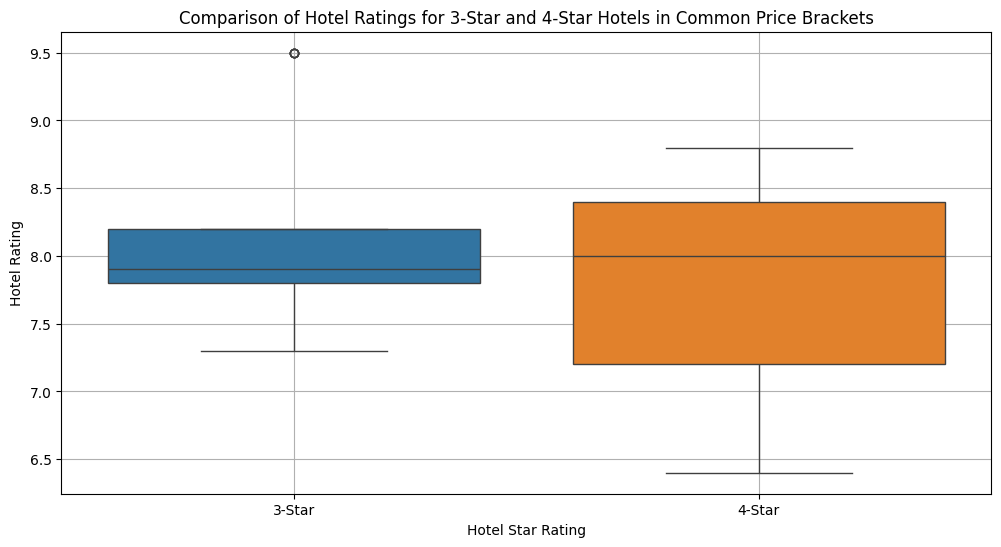

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=common_hotels[['Hotel Rating_3_star', 'Hotel Rating_4_star']])
plt.title('Comparison of Hotel Ratings for 3-Star and 4-Star Hotels in Common Price Brackets')
plt.xlabel('Hotel Star Rating')
plt.ylabel('Hotel Rating')
plt.xticks([0, 1], ['3-Star', '4-Star'])
plt.grid()
plt.show()


#### This section performs a T-test to compare hotel ratings between 3-star and 4-star hotels within the same price range. It then calculates the average ratings for both groups, grouped by price range, to further compare their mean ratings.

In [ ]:
from scipy import stats

t_stat, p_value = stats.ttest_ind(
    common_hotels['Hotel Rating_3_star'].dropna(),
    common_hotels['Hotel Rating_4_star'].dropna()
)
print(f'T-test results: t-statistic={t_stat:.2f}, p-value={p_value:.3f}')


T-test results: t-statistic=1.91, p-value=0.060


In [ ]:
# Calculate average ratings for 3-star and 4-star hotels within the same price range
average_ratings = common_hotels.groupby('Price Range').agg({
    'Hotel Rating_3_star': 'mean',
    'Hotel Rating_4_star': 'mean'
}).reset_index()

print(average_ratings)


  Price Range  Hotel Rating_3_star  Hotel Rating_4_star
0        <100                  NaN                  NaN
1     100-200                  7.8             7.328571
2     200-300                  8.5             8.160000
3     300-400                  NaN                  NaN
4     400-500                  NaN                  NaN
5     500-600                  NaN                  NaN
6     600-700                  NaN                  NaN
7     700-800                  NaN                  NaN
8     800-900                  NaN                  NaN
9        900+                  NaN                  NaN


<ipython-input-131-9ff631b9d357>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_ratings = common_hotels.groupby('Price Range').agg({


#### This section calculates the skewness of 3-star and 4-star hotel ratings to assess the distribution shape, followed by a T-test to compare their average ratings for statistical significance.


In [ ]:
# Calculate skewness
skewness_3_star = common_hotels['Hotel Rating_3_star'].dropna().skew()
skewness_4_star = common_hotels['Hotel Rating_4_star'].dropna().skew()
print(f'Skewness of 3-Star Ratings: {skewness_3_star:.2f}')
print(f'Skewness of 4-Star Ratings: {skewness_4_star:.2f}')


Skewness of 3-Star Ratings: 1.13
Skewness of 4-Star Ratings: -0.47


In [ ]:
t_stat, p_value = stats.ttest_ind(
    common_hotels['Hotel Rating_3_star'].dropna(),
    common_hotels['Hotel Rating_4_star'].dropna()
)
print(f'T-test results: t-statistic={t_stat:.2f}, p-value={p_value:.3f}')


T-test results: t-statistic=1.91, p-value=0.060


Conclusion
Average Ratings: If the average rating for 3-star hotels is higher than for 4-star hotels in a specific price range, it indicates greater satisfaction among guests for that category.

Distribution: If the ratings for 3-star hotels show less variability (lower standard deviation) and a more positive skew, it suggests consistent satisfaction.

Statistical Significance: If the p-value from the t-test is below a certain threshold (commonly 0.05), you can conclude that the difference in ratings between the two groups is statistically significant.
But we need to gather more valid data to perform this analysis so its still in priliminary phase.

##**Step 4: User Interaction:**
*   **Input Preferences:** User specifies price range, rating, stars, and refund
*   **Filter Hotels:** Hotels matching the user’s preferences are filtered.
*   **Sort Options:** User can sort by price, rating, or stars.
*   **Display Results:** Filtered hotels are displayed with key details and images.

*   **Hotel Details:** User can request detailed info about any hotel.
*   **Exit:** User can exit anytime by typing 'exit'.





In [ ]:
from IPython.display import display, HTML

def get_user_preferences():
    print("Please enter your preferences (or type 'exit' to quit):")
    min_price = input("Enter minimum price in $: ")
    if min_price.lower() == 'exit':
        return None

    max_price = input("Enter maximum price in $: ")
    if max_price.lower() == 'exit':
        return None

    min_review = input("Enter minimum Hotel Rating (1-10): ")
    if min_review.lower() == 'exit':
        return None

    min_stars = input("Enter minimum star rating (1-5) or type 'skip' to ignore: ")
    if min_stars.lower() == 'exit':
        return None

    refundable = input("Do you want refundable options only? (Yes/No): ").capitalize()
    if refundable.lower() == 'exit':
        return None


    return (
        float(min_price),
        float(max_price),
        float(min_review),
        min_stars.lower(),
        refundable
    )

def filter_hotels(min_price, max_price, min_review, min_stars, refundable):
    filtered_hotels = df[
        (df['Price'] >= min_price) &
        (df['Price'] <= max_price) &
        (df['Hotel Rating'] >= min_review)
    ]

    if refundable == 'Yes':
        filtered_hotels = filtered_hotels[filtered_hotels['Refundable'] == 1]

    if min_stars != 'skip':
        filtered_hotels = filtered_hotels[filtered_hotels['Stars'].notna() &
                                           (filtered_hotels['Stars'] >= int(min_stars))]


    return filtered_hotels

def get_sort_criteria():
    print("\nSort hotels by:")
    print("1. Price")
    print("2. Hotel Rating")
    print("3. Stars")
    sort_option = int(input("Enter the number corresponding to your choice: "))

    if sort_option == 1:
        sort_by = 'Price'
    elif sort_option == 2:
        sort_by = 'Hotel Rating'
    elif sort_option == 3:
        sort_by = 'Stars'
    else:
        print("Invalid choice. Defaulting to sorting by price.")
        sort_by = 'Price'

    return sort_by

def display_filtered_hotels(filtered_hotels):
    print("\nHere are the hotels based on your preferences:")

    # Add image HTML rendering
    filtered_hotels['Image'] = filtered_hotels['Images'].apply(
        lambda x: f'<img src="{x[0]}" width="150" height="150">' if x else 'No Image Available'
    )

    # Select and reorder columns to display the desired output
    display_df = filtered_hotels[['Hotel Name', 'Price', 'Stars', 'Hotel Rating', 'Image']]

    # Render the DataFrame as HTML for displaying in Jupyter
    display(HTML(display_df.to_html(escape=False)))

def get_hotel_details(hotel_name):
    hotel = df[df['Hotel Name'] == hotel_name]

    if hotel.empty:
        print("Hotel not found!")
        return

    print("\nHotel Information:")
    print(f"Name: {hotel.iloc[0]['Hotel Name']}")
    print(f"Address: {hotel.iloc[0]['Hotel Address']}")
    print(f"Price: ${hotel.iloc[0]['Price']} per night")
    print(f"Hotel Rating: {hotel.iloc[0]['Hotel Rating']}/10")
    print(f"Stars: {hotel.iloc[0]['Stars']}")

    print("\nPhotos:")
    display_images(hotel.iloc[0]['Images'])

def display_images(photo_urls):
    image_html = ''.join(
        f'<img src="{url}" width="150" height="150" style="margin: 5px;">'
        for url in photo_urls
    )
    display(HTML(image_html))

def display_image_placeholder(photo_urls):
    for url in photo_urls:
        print(f"[Image] Placeholder for image: {url}")  # This simulates image display

def prompt_agent():
    preferences = get_user_preferences()
    if preferences is None:
        return  # Exit if user types 'exit'

    min_price, max_price, min_review, min_stars, refundable = preferences
    filtered_hotels = filter_hotels(min_price, max_price, min_review, min_stars, refundable)

    if filtered_hotels.empty:
        print("No hotels match your preferences.")
        return  # Ask for preferences again

    sort_by = get_sort_criteria()
    sorted_hotels = filtered_hotels.sort_values(by=sort_by, ascending=True)

    display_filtered_hotels(sorted_hotels)

In [ ]:
prompt_agent()

Please enter your preferences (or type 'exit' to quit):
Enter minimum price in $: 1
Enter maximum price in $: 1000
Enter minimum Hotel Rating (1-10): 1
Enter minimum star rating (1-5) or type 'skip' to ignore: skip
Do you want refundable options only? (Yes/No): Yes

Sort hotels by:
1. Price
2. Hotel Rating
3. Stars
Enter the number corresponding to your choice: 2

Here are the hotels based on your preferences:


,Hotel Name,Price,Stars,Hotel Rating,Image
68,Signature Inn Hotel - Free Parking,87.0,NaN,5.4,
57,"Ramee Royal Hotel, Dubai",73.0,NaN,6.0,
75,Capitol Hotel Jumeirah Dubai,131.0,NaN,6.6,
97,Route 66,27.0,NaN,7.3,
58,Vintage Grand Hotel,77.0,NaN,7.6,
101,Brand New Boys Hostel,10.0,NaN,7.6,
52,Holiday International Hotel – Embassy District,167.0,NaN,7.8,
55,Al Habtoor Polo Resort,348.0,NaN,7.8,
67,"The George Hotel by Saffron, Dubai Creek",126.0,NaN,7.8,
94,Next'House - Business Bay Central Hostel,63.0,NaN,8.1,


In [ ]:
# you can see some images are same in above results and the reason is, the site (hostel world) was using lazy loading with some JS library to show images in respective hotel block. That was causing image replication while scrapping.

In [ ]:
hotel_name = input("\nEnter the name of the hotel you want details about (or type 'exit' to quit): ")
if not (hotel_name.lower() == 'exit'):
    get_hotel_details(hotel_name)
print("Exiting...")


Enter the name of the hotel you want details about (or type 'exit' to quit): The George Hotel by Saffron Dubai Creek

Hotel Information:
Name: The George Hotel by Saffron Dubai Creek
Address: Baniyas Rd - Deira - Al Ras - Dubai, DUBAI
Price: $160.0 per night
Hotel Rating: 8.2/10
Stars: 3.0

Photos:


Exiting...
